# U.S. Traffic Casualty Analysis - Pre-processing & Modeling

## 2.1 Preprocessing

### 2.1.1 Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from collections import Counter

In [3]:
accidents = pd.read_csv('accidents.csv')

In [4]:
accidents.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
accidents.Weather_Timestamp

0          2016-02-08 00:53:00
1          2016-02-08 05:58:00
2          2016-02-08 05:53:00
3          2016-02-08 06:54:00
4          2016-02-08 07:53:00
                  ...         
2845337    2019-08-23 17:53:00
2845338    2019-08-23 18:53:00
2845339    2019-08-23 18:53:00
2845340    2019-08-23 18:51:00
2845341    2019-08-23 20:50:00
Name: Weather_Timestamp, Length: 2845342, dtype: object

In [6]:
accidents.Weather_Condition

0             Light Rain
1             Light Rain
2               Overcast
3               Overcast
4             Light Rain
               ...      
2845337             Fair
2845338             Fair
2845339    Partly Cloudy
2845340             Fair
2845341             Fair
Name: Weather_Condition, Length: 2845342, dtype: object

### 2.1.2 Feature Engineering

Creatinga a new column called `Duration(h)` to record how long the accident was happeningsubtracting end time with the start time of the accident.

In [9]:
accidents['Duration(h)']=(pd.to_datetime(accidents.End_Time)-pd.to_datetime(accidents.Start_Time)).astype('timedelta64[h]')

In [14]:
accidents['Duration(h)'].describe()

count    2.845342e+06
mean     5.611845e+00
std      1.554944e+02
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      2.804200e+04
Name: Duration(h), dtype: float64

Looks like the average time of an accident is 5.61 hours nation wide!

### 2.1.3 Feature Elimination

Since our goals is to predict severity and duration of the accidents, some features such as addresses, coordinates, and near by airport don't really help here, so we are dropping those features

In [15]:
accidents = accidents.drop(columns = ["ID","Number","Street","Side","City","County","State","Zipcode","Country","Timezone","Airport_Code","Start_Lat","Start_Lng","End_Lat","End_Lng"])

In [16]:
accidents.head()

,Severity,Start_Time,End_Time,Distance(mi),Description,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration(h)
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,...,False,False,False,False,False,Night,Night,Night,Night,6.0
1,2,2016-02-08 05:56:20,2016-02-08 11:56:20,0.747,At OH-4/OH-235/Exit 41 - Accident.,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,...,False,False,False,False,False,Night,Night,Night,Night,6.0
2,2,2016-02-08 06:15:39,2016-02-08 12:15:39,0.055,At I-71/US-50/Exit 1 - Accident.,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,...,False,False,False,False,False,Night,Night,Night,Day,6.0
3,2,2016-02-08 06:51:45,2016-02-08 12:51:45,0.123,At Dart Ave/Exit 21 - Accident.,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,...,False,False,False,False,False,Night,Night,Day,Day,6.0
4,3,2016-02-08 07:53:43,2016-02-08 13:53:43,0.500,At Mitchell Ave/Exit 6 - Accident.,2016-02-08 07:53:00,37.0,29.8,93.0,29.69,...,False,False,False,False,False,Day,Day,Day,Day,6.0


From the preceding notebook (Data Wrangling & Exploratory Data Analysis), the three fields with the highest % of missing values for the 'accidents' dataset are Numbers, Precipitation(in), and Wind_Chili(F). After dropping a few unnecessary columns, the three features with highest % of missing values are:
* `Precipitation(in)` shows precipitation amount in inches, if there is any. 
* `Wind_Chili(F)` shows the wind chill (in Fahrenheit).
* `Wind_Speed(mph)` shows wind speed (in miles per hour).

In [17]:
missing_accidents = pd.concat([accidents.isnull().sum(), 100 * accidents.isnull().mean()], axis=1)
missing_accidents.columns=['count','%']
missing_accidents.sort_values(by=['%'], ascending=False)

,count,%
Precipitation(in),549458,19.310789
Wind_Chill(F),469643,16.505678
Wind_Speed(mph),157944,5.550967
Wind_Direction,73775,2.592834
Humidity(%),73092,2.568830
Weather_Condition,70636,2.482514
Visibility(mi),70546,2.479350
Temperature(F),69274,2.434646
Pressure(in),59200,2.080593
Weather_Timestamp,50736,1.783125


For these specific missing values in weather, we want to replace them with the average value

In [20]:
wind_mean_value = accidents['Wind_Chill(F)'].mean()
preci_mean_value = accidents['Precipitation(in)'].mean()
windspeed_mean_value = accidents['Wind_Speed(mph)'].mean()

In [21]:
accidents['Wind_Chill(F)'].fillna(value=wind_mean_value, inplace=True)
accidents['Precipitation(in)'].fillna(value = preci_mean_value,inplace=True)
accidents['Wind_Speed(mph)'].fillna(value = windspeed_mean_value,inplace=True)

Let's take a look at the missing values again

In [22]:
missing_accidents = pd.concat([accidents.isnull().sum(), 100 * accidents.isnull().mean()], axis=1)
missing_accidents.columns=['count','%']
missing_accidents.sort_values(by=['%'], ascending=False)

,count,%
Wind_Direction,73775,2.592834
Humidity(%),73092,2.568830
Weather_Condition,70636,2.482514
Visibility(mi),70546,2.479350
Temperature(F),69274,2.434646
Pressure(in),59200,2.080593
Weather_Timestamp,50736,1.783125
Astronomical_Twilight,2867,0.100761
Nautical_Twilight,2867,0.100761
Civil_Twilight,2867,0.100761


Since the rest of the missing value rows are comparartively small amount compared to our dataset, let's drop them

In [24]:
accidents.dropna(inplace=True)

In [25]:
accidents.isna().sum()

Severity                 0
Start_Time               0
End_Time                 0
Distance(mi)             0
Description              0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
Duration(h)              0
dtype: int64

### 2.1.4 Correlation

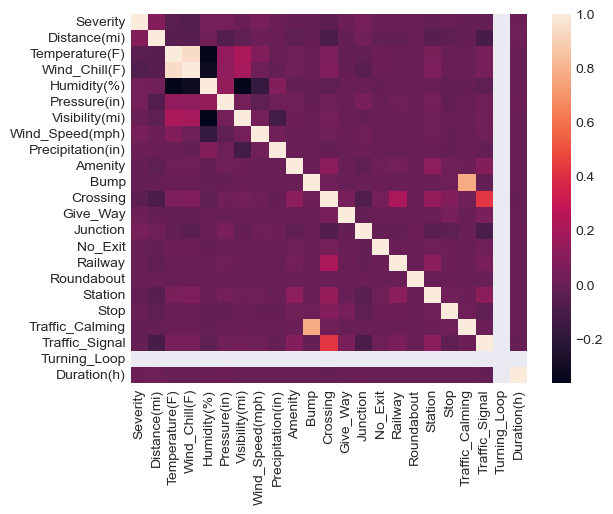

In [26]:
corr = accidents.corr()

heat = sns.heatmap(corr)

Understanding how the features in a dataset interact with each other is crucial when deciding which features to use in a model. There are many ways to construct a model that is effective and accurate. One of the fastest ways to strengthen a model is to identify and reduce the features in the dataset that are highly correlated. Correlated features will add noise and inaccuracy to a model, which in turn will make it harder to achieve the desired outcome.

Highly correlated variables should be avoided when creating models is because they can skew the output. If there are two independent variables that are representing the same occurrence (i.e SqFt of a house vs bedrooms in a house) it can create “noise” or inaccuracy in the model. Models rely solely on outside information in order to create a useful output and having colinear (correlated) variables can create an inflated variance in at least one of the regression outputs.

Text(0.5, 1.0, 'Multi-Collinearity of Accidents Features')

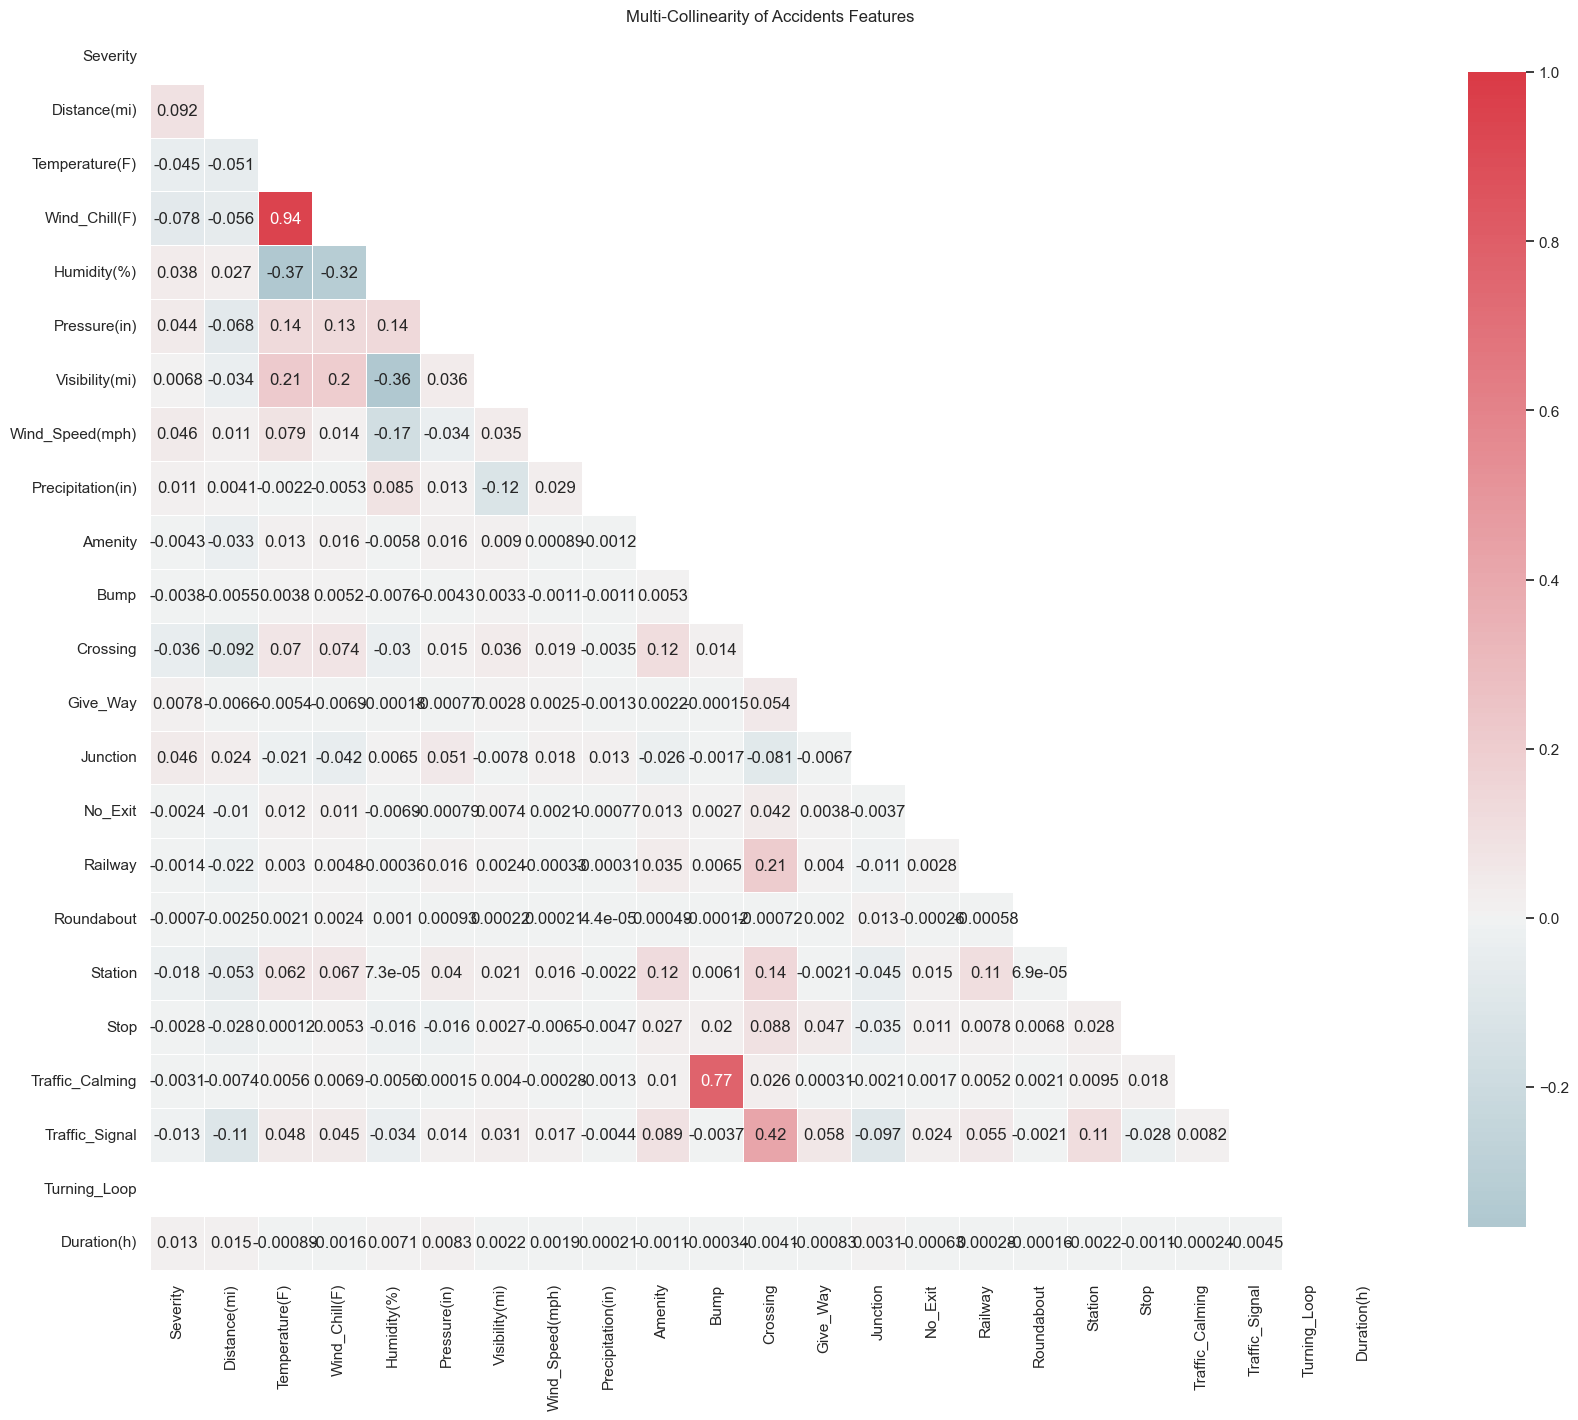

In [34]:
#Correlation heatmap for accidents data
sns.set(style="white")

# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot=True,mask=mask,cmap=cmap,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Accidents Features')